# Project 4 NMF and clustering

In [42]:
import spacy
import scispacy
import pickle
import numpy as np
import pandas as pd
import re
import en_ner_bionlp13cg_md
from sklearn.cluster import KMeans
from gensim.models import nmf
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

In [3]:
nlp = en_ner_bionlp13cg_md.load()

Tokenizer setting split on '/' also (genes are often seperated by this in abstracts)

In [4]:
infixes = nlp.Defaults.infixes + (r'''/''',)
infix_regex = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_regex.finditer

Add step to spacy pipeline to merge identified entities into chunks

In [5]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

The tokens I'll want to keep from spacy are those labeled as entities by scispacy's ner and longer than one character

In [6]:
def keep_token(t):
    return (t.ent_type != 0) and (t.__len__() > 1)

Import my list of title+abstract documents

In [1]:
import os
os.chdir('/Volumes/BethMac/Metis Proj 4 data/')

In [9]:
with open('title_abstract_docs_list.pickle', 'rb') as read_file:
    abstracts = pickle.load(read_file)

In [10]:
len(abstracts)

337871

There are new line characters in the abstracts that should be removed

In [12]:
abstracts = list(map(lambda x: re.sub('\\n',' ', x),abstracts))

Initiate the nlp.pipe generator abstract, for running nlp on my abstracts. Disable the tagger and parser since I won't use thier output and it will be faster

In [20]:
nlp_abstracts = nlp.pipe(abstracts, disable=["tagger","parser"])

Run through the documents and collect the cleaned lemmatized lowercase tokens that are also named entities. Append the type of named entity to the end of the token for later

In [21]:
docs = []
count = 0

for doc in nlp_abstracts:
    docs.append([re.sub('[)(]|\-$','',t.lemma_.lower())+"_"+t.ent_type_ for t in doc if keep_token(t)])
    count += 1
    if count%1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

I can now easily use the tags appended to the docs token list to test NMF with different combinations of entites. Genes/Gene products only worked the best. This included many small molecules as well that were missclassified but I think that was good for my application.

In [1121]:
docs_genes = []
for doc in docs:
    docs_genes.append([t for t in doc if (t.find("GENE") != -1) and (t.startswith('doi_') != True) and t.startswith('usa_') != True and t.startswith('boston_') != True and t.startswith("uk_") != True and t.startswith('gfp_') != True and t.startswith('luciferase_') != True and t.startswith('/_') != True and t.startswith('e.g._') != True and t.startswith('microm.') != True ])

In [1122]:
len(docs_genes)

337871

The gensim Dictionary originally contains all the tokens, I can filter out tokens that appear in less than 5 documents or more than 10% of documents to reduce the number of tokens in NMF

In [1123]:
docs_dict = Dictionary(docs_genes)

In [1124]:
len(docs_dict)

362425

In [1125]:
docs_dict.filter_extremes(no_below=5, no_above=0.1)

In [1126]:
docs_dict.compactify()

In [1127]:
len(docs_dict)

41089

Create the bag of words representation of my documents using the tokens from the dictionary

In [1128]:
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]

The TFIDF matrix is created 

In [1129]:
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)

In [1130]:
docs_tfidf  = model_tfidf[docs_corpus]

Use gensim's nmf model to find latent topics. 25 topics gave readily reconizable gene lists

In [722]:
nmf_result = nmf.Nmf(docs_tfidf, num_topics=25)

In [1]:
os.chdir('/Volumes/BethMac/Metis Proj 4 data/')

The model and dictionary were pickled earlier and reloaded

In [2]:
with open('A_25_topic_nmf.pickle', 'rb') as read_file:
    nmf = pickle.load(read_file)

with open('dict_for_nmf.pickle', 'rb') as read_file:
    doc_dict = pickle.load(read_file)
    
with open('docs_for_nmf.pickle', 'rb') as read_file:
    docs = pickle.load(read_file)    

This method retrieves the topic-term matrix from nmf

In [34]:
nmf_term_topic = nmf.get_topics()

There are a lot of 0 values in this matrix

In [35]:
sum(nmf_term_topic[1] > 0)

14051

In [36]:
nmf_term_topic.shape

(25, 30642)

Put this into a labeled dataframe I can sort to see top terms in each topic

In [39]:
nmf_term_topic = pd.DataFrame(nmf_term_topic)

In [41]:
nmf_term_topic.columns = doc_dict.values()

In [42]:
nmf_term_topic = nmf_term_topic.transpose()


- nmf 0 = IFNs, jak
- nmf 1 = p53
- nmf 2 = b-cell and toll like
- nmf 3 = nitric oxide
- nmf 4 = camp
- nmf 5 = nfkb
- nmf 6 = wnt and tgfb
- nmf 7 = g-protein receptors
- nmf 8 = interleukins, jak
- nmf 9 = mtor and akt
- nmf 10 = insulin and igf
- nmf 11 = thrombin, clotting
- nmf 12 = egfr
- nmf 13 = androgen and nfkb
- nmf 14 = notch
- nmf 15 = pkc and lipids
- nmf 16 = unfolded protein response, er and golgi
- nmf 17 = actin and tyrosine-kinase receptors
- nmf 18 = integrin adhesion
- nmf 19 = t-cell receptor
- nmf 20 = chemotaxis
- nmf 21 = pkc and calcium
- nmf 22 = extrinsic apoptosis
- nmf 23 = IL-6, intrinsic apoptosis
- nmf 24 = tnf-alpha, tgfb, serotonin

In [150]:
nmf_term_topic.sort_values(21,ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
pkc_GENE_OR_GENE_PRODUCT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.635109e-03,0.000000,0.295121,0.000000,0.000000,0.000004
protein kinase c_GENE_OR_GENE_PRODUCT,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000733,0.000000,...,0.305021,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.027193,0.000000,0.000000,0.000277
pka_GENE_OR_GENE_PRODUCT,0.000800,0.000000,0.000000,0.000000,0.049709,0.000161,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000354,0.002053,0.000029,0.000000e+00,0.000000,0.017074,0.000000,0.000000,0.000000
erk_GENE_OR_GENE_PRODUCT,0.000000,0.008075,0.000000,0.000000,0.002857,0.026337,0.000000,0.003030,0.001082,0.003666,...,0.000000,0.000000,0.037148,0.003786,0.000000e+00,0.000000,0.009583,0.000000,0.001108,0.000000
mapk_GENE_OR_GENE_PRODUCT,0.000000,0.006970,0.000000,0.000000,0.002468,0.025660,0.000000,0.001278,0.001148,0.001693,...,0.000000,0.000000,0.022045,0.000000,4.642342e-04,0.000000,0.009246,0.000000,0.000670,0.000000
pkcalpha_GENE_OR_GENE_PRODUCT,0.000021,0.000084,0.000000,0.000000,0.000000,0.000360,0.000000,0.000110,0.000399,0.000013,...,0.000333,0.000031,0.000050,0.000216,0.000000e+00,0.000000,0.009243,0.000000,0.000018,0.000194
erk1_GENE_OR_GENE_PRODUCT,0.000000,0.002342,0.000000,0.000000,0.003623,0.009938,0.000000,0.000650,0.001001,0.001721,...,0.000000,0.000418,0.011343,0.002552,0.000000e+00,0.000000,0.008541,0.000000,0.001776,0.000326
plc_GENE_OR_GENE_PRODUCT,0.000000,0.000079,0.000000,0.000028,0.000226,0.000000,0.000000,0.029261,0.000000,0.000551,...,0.000874,0.000207,0.000141,0.000000,0.000000e+00,0.000000,0.007386,0.000000,0.000000,0.000470
pkcs_GENE_OR_GENE_PRODUCT,0.000000,0.000024,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000045,...,0.001038,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.007009,0.000000,0.000000,0.000000
pkc alpha_GENE_OR_GENE_PRODUCT,0.000018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000020,0.000000,0.000014,1.152071e-07,0.000000,0.005440,0.000000,0.000000,0.000000


recreate the docs corpus

In [3]:
docs_corpus = [doc_dict.doc2bow(doc) for doc in docs]

In [4]:
doc_topics = nmf.get_document_topics(docs_corpus)

In [5]:
len(doc_topics)

337871

The get_document_topics method returned lists for each document of its score for any topic that was above zero. I converted this to a matrix using a loop

In [8]:
doc_topic_matrix = np.zeros((337871,25))

In [9]:
for i, doc in enumerate(doc_topics):
    for p in doc:
        doc_topic_matrix[i,p[0]] = p[1]
    

In [10]:
doc_topic_matrix.shape

(337871, 25)

Some of these documents have no score above zero for any topic, so I excluded them from further analysis

In [11]:
keep_abstract = doc_topic_matrix.sum(axis=1)!= 0

In [12]:
doc_topic_matrix[keep_abstract].shape

(294319, 25)

In [13]:
doc_topic_matrix = doc_topic_matrix[keep_abstract]

I looked at the inertia from k-means clustering of the documents along the 25 latent topic dimensions and plotted them. This curve had an elbow around 25 or 30 suggesting that was an appropriate number of clusters for the data.

In [179]:
inertias = []

for k in np.arange(25, 55, 5):
    km = KMeans(n_clusters=k)
    km.fit(doc_topic_matrix)
    inertias.append(km.inertia_)

In [184]:
for k in np.arange(55, 80, 5):
    km = KMeans(n_clusters=k)
    km.fit(doc_topic_matrix)
    inertias.append(km.inertia_)

In [190]:
inertias_low = []
for k in np.arange(10, 25, 5):
    km = KMeans(n_clusters=k)
    km.fit(doc_topic_matrix)
    inertias_low.append(km.inertia_)

In [191]:
intertias_2 = inertias_low + inertias

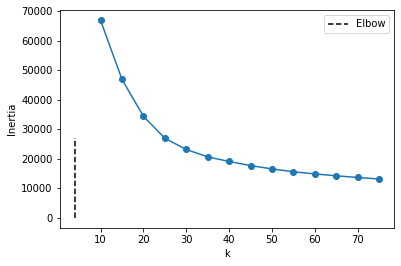

In [192]:
plt.plot(np.arange(10, 80, 5), intertias_2, marker='o')
plt.vlines(x=4, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();

I used 30 clusters here for k-means

In [94]:
km = KMeans(n_clusters=30)
km.fit(doc_topic_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [275]:
#with open('kmeans_on_nmf_25.pickle', 'wb') as write_file:
#    pickle.dump(km, write_file)

In [38]:
with open('kmeans_on_nmf_25.pickle', 'rb') as read_file:
    km = pickle.load(read_file)

In [39]:
len(km.labels_)

294319

In [40]:
cluster_centers = km.cluster_centers_

I found the size of the clusters 

In [48]:
cluster_sizes = pd.Series(Counter(km.labels_)).sort_index()

In [49]:
cluster_sizes

0      5241
1     14154
2     13188
3     18853
4      7204
5     12672
6      8325
7     14425
8      7261
9      5787
10     6259
11     8490
12    10347
13     9899
14    11999
15    13825
16     6060
17     5102
18    11128
19     2676
20    14464
21     9471
22     6765
23    31391
24     3138
25     4675
26     3001
27     7604
28    12819
29     8096
dtype: int64

Because calculating a tSNE for all ~300k documents and plotting them was time-consuming, I used the cluster centers with tSNE. I had to adjust the hyperparameters to be more appropriate for a small number of points

In [43]:
clusters_embedded = TSNE(n_components=2, learning_rate=10, perplexity=4).fit_transform(cluster_centers)

In [44]:
x = [i[0] for i in clusters_embedded]

In [45]:
y = [i[1] for i in clusters_embedded]

In [46]:
cluster_colors=np.arange(0,30)

I ploted the cluster centers in bubbles that are relative to the cluster sizes and label with names I determined below (note: topic_labels does not exist at this point in the notebook for labeling)

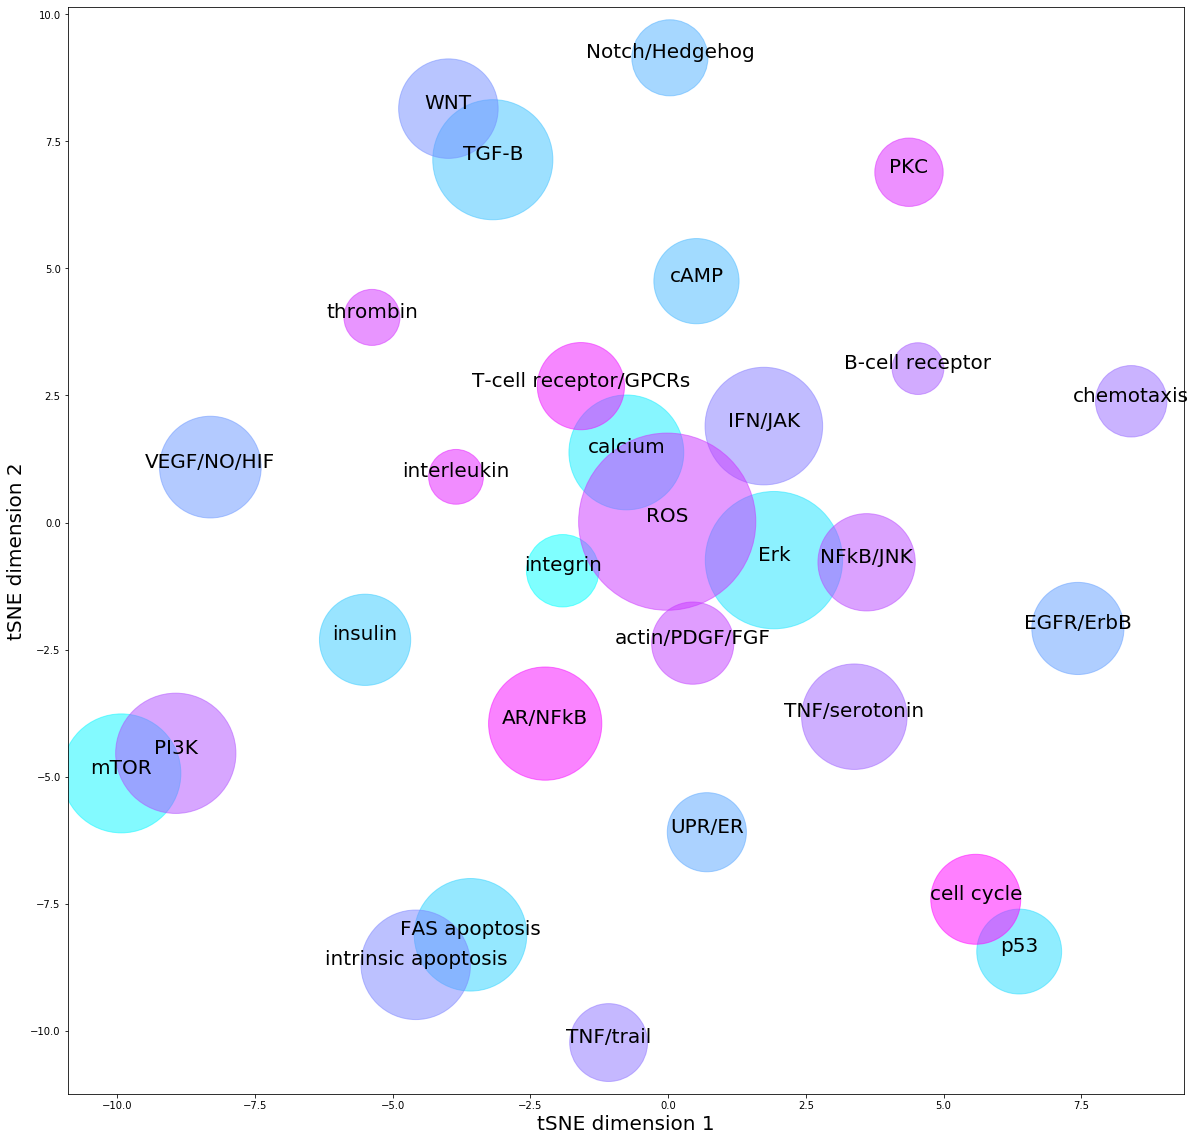

In [50]:
plt.figure(figsize=(20,20))
plt.scatter(x,y, 
            c = cluster_colors, s=(cluster_sizes), cmap="cool", alpha=0.5)
i=-1
for x_lab,y_lab in zip(x,y):
    i +=1
    plt.annotate(topic_labels[i],(x_lab,y_lab), ha="center", fontsize=20)

plt.xlabel('tSNE dimension 1',fontsize=20)
plt.ylabel('tSNE dimension 2', fontsize=20)

plt.savefig('tSNE_3.jpg')

To find the top mentioned genes in each cluster, I subsetted the docs list to only the ones I used for clustering. I made a dictionary that contained a series object of all the gene/gene product tokens associated with documenst with each cluster label and thier relative mention frequency which I defined as counts in cluster / cluster_size x 100.

In [121]:
len(docs)

337871

In [525]:
keep_docs = np.array(docs)

In [526]:
keep_docs = keep_docs[keep_abstract]

In [527]:
len(keep_docs)

294319

In [528]:
sum(keep_abstract)

294319

In [529]:
keep_docs = pd.DataFrame({'genes':keep_docs, 'label':km.labels_})

In [568]:
from collections import defaultdict
genes_dict = defaultdict(list)

for i in range(0,30):
    group = keep_docs[keep_docs['label']==i]['genes']
    group = [g.replace("_GENE_OR_GENE_PRODUCT",'') for j in list(group) for g in j]
    genes_dict[i]= pd.Series(group).value_counts()/cluster_sizes[i]*100

Look at the top genes in each cluster to assign labels below

In [33]:
genes_dict[0].head(10)

integrin                 204.464797
fak                       63.480252
fibronectin               21.484450
focal adhesion kinase     19.996184
ilk                       18.450677
paxillin                  12.955543
src                       12.192330
collagen                   9.711887
igg                        7.536730
laminin                    7.116962
dtype: float64

In [37]:
topic_labels=['integrin','mTOR','calcium','Erk','p53','FAS apoptosis','insulin','TGF-B','cAMP','Notch/Hedgehog'\
             ,'UPR/ER','EGFR/ErbB','VEGF/NO/HIF','WNT','intrinsic apoptosis','IFN/JAK','TNF/trail'\
             ,'chemotaxis','TNF/serotonin','B-cell receptor','PI3K','NFkB/JNK','actin/PDGF/FGF','ROS','thrombin'\
             ,'PKC', 'interleukin', 'T-cell receptor/GPCRs', 'AR/NFkB', 'cell cycle']

Here I made a similar dictionary of entity tokens for each document that were NOT Gene/Gene product. Again I'm removing some stop word tokens.

In [227]:
with open('docs_annotated_ner.pickle', 'rb') as read_file:
    docs_ner = pickle.load(read_file)

In [228]:
docs_other = []
for doc in docs_ner:
    docs_other.append([t for t in doc if (t.find("GENE") == -1) and (t.startswith('doi_') != True) and t.startswith('usa_') != True and t.startswith('boston_') != True and t.startswith("uk_") != True and t.startswith('gfp_') != True and t.startswith('luciferase_') != True and t.startswith('/_') != True and t.startswith('e.g._') != True and t.startswith('microm.') != True ])

In [229]:
len(docs_other)

337871

In [230]:
keep_docs = np.array(docs_other)

The documents that couldn't be scored above 0 for any topic were removed using the keep_abstract vector from above

In [231]:
keep_docs = keep_docs[keep_abstract]

In [233]:
sum(keep_abstract)

294319

In [237]:
keep_docs = pd.DataFrame({'other':keep_docs, 'label':km.labels_})

In [523]:
keep_docs.head()

,other,label
0,"[rat hypothalamus_ORGANISM, neurointermediate ...",7
1,"[human interleukin-2_ORGANISM, mouse cells_ORG...",26
2,"[human natural killer cells_ORGANISM, manuscri...",19
3,"[blood glucose_ORGANISM_SUBSTANCE, intravenous...",6
4,"[phorbol ester_SIMPLE_CHEMICAL, human hematopo...",25


In [521]:
from collections import defaultdict
other_dict = defaultdict(list)

for i in range(0,30):
    group = keep_docs[keep_docs['label']==i]['other']
    group = [re.sub("_.*",'', g) for j in list(group) for g in j]
    other_dict[i]= pd.Series(group).value_counts()/cluster_sizes[i]*100

In [56]:
other_dict[0].head(10)

cell                    226.521656
tumor                    29.002099
extracellular matrix     28.620492
cellular                 27.399351
platelet                 23.392482
cancer                   19.538256
ecm                      19.175730
tissue                   17.916428
matrix                   16.676207
intracellular            14.596451
dtype: float64

In [541]:
#with open('genes_dict.pickle','wb') as write_file:
#    pickle.dump(genes_dict,write_file)
#with open('other_dict.pickle','wb') as write_file:
#    pickle.dump(other_dict, write_file)

In [3]:
import pickle

In [4]:
with open('genes_dict.pickle','rb') as read_file:
    genes_dict = pickle.load(read_file)
with open('other_dict.pickle','rb') as read_file:
    other_dict = pickle.load(read_file)

I made some functions to output the top categories for either gene tokens or other entity tokens

In [10]:
def top_categories_other(string):
    '''
    Take a token string and output it's representation in different clusters
    Representation is (total counts) / (cluster size) * 100
    '''
    output=[]
    for i in range(30):
        try:
            output.append((topic_labels[i],other_dict[i][string]))
        except:
            continue
    return sorted(output, key=lambda x: x[1], reverse=True)

In [22]:
top_categories_other('mitochondria')

[('intrinsic apoptosis', 1.4084507042253522),
 ('UPR/ER', 1.2621824572615434),
 ('FAS apoptosis', 0.7733585858585859),
 ('VEGF/NO/HIF', 0.5702135884797526),
 ('insulin', 0.5165165165165164),
 ('PI3K', 0.283462389380531),
 ('p53', 0.27762354247640203),
 ('cell cycle', 0.25938735177865613),
 ('ROS', 0.2484788633684814),
 ('calcium', 0.24264482863208978),
 ('actin/PDGF/FGF', 0.17738359201773835),
 ('TNF/trail', 0.16501650165016502),
 ('mTOR', 0.14130281192595734),
 ('cAMP', 0.13772207684891888),
 ('AR/NFkB', 0.1326156486465403),
 ('PKC', 0.1283422459893048),
 ('Erk', 0.12730069484962606),
 ('TNF/serotonin', 0.11682242990654204),
 ('B-cell receptor', 0.11210762331838565),
 ('IFN/JAK', 0.108499095840868),
 ('NFkB/JNK', 0.10558547143912997),
 ('Notch/Hedgehog', 0.10368066355624676),
 ('chemotaxis', 0.09800078400627205),
 ('TGF-B', 0.09012131715771231),
 ('T-cell receptor', 0.07890583903208837),
 ('interleukin', 0.06664445184938354),
 ('thrombin', 0.06373486297004462),
 ('integrin', 0.0572409

In [23]:
def top_categories(string):
    '''
    Take a gene token string and output it's representation in different clusters
    Representation is (total counts) / (cluster size) * 100
    '''
    output=[]
    for i in range(30):
        try:
            output.append((topic_labels[i],genes_dict[i][string]))
        except:
            continue
    return sorted(output, key=lambda x: x[1], reverse=True)

In [36]:
top_categories('vdr')

[('ROS', 2.8670638080978623),
 ('WNT', 1.7476512779068594),
 ('NFkB/JNK', 0.7813324886495618),
 ('Erk', 0.7531957778602875),
 ('TNF/trail', 0.6600660066006601),
 ('TGF-B', 0.6447140381282496),
 ('PKC', 0.6417112299465241),
 ('cell cycle', 0.6299407114624506),
 ('IFN/JAK', 0.5424954792043399),
 ('AR/NFkB', 0.5226616740775412),
 ('UPR/ER', 0.4473558076370027),
 ('cAMP', 0.3993940228618648),
 ('chemotaxis', 0.31360250882007057),
 ('intrinsic apoptosis', 0.25002083506958916),
 ('p53', 0.2498611882287618),
 ('FAS apoptosis', 0.23674242424242425),
 ('calcium', 0.23506217773733698),
 ('EGFR/ErbB', 0.22379269729093051),
 ('PI3K', 0.19358407079646017),
 ('Notch/Hedgehog', 0.15552099533437014),
 ('actin/PDGF/FGF', 0.08869179600886917),
 ('insulin', 0.08408408408408409),
 ('TNF/serotonin', 0.08087706685837527),
 ('interleukin', 0.06664445184938354),
 ('T-cell receptor', 0.052603892688058915),
 ('mTOR', 0.04945598417408506),
 ('B-cell receptor', 0.03736920777279522),
 ('thrombin', 0.03186743148502

In [55]:
def plot_top_categories(string):
    '''
    Plot a bar graph of category representation for gene token
    '''
    output = top_categories(string)
    colors = plt.cm.cool(np.linspace(0.1,0.9,10))[::-1]
    plt.figure(figsize=(10,5))
    plt.bar(x=range(len(output)),height=list(map(lambda x:x[1],output)),color=colors,alpha=0.5)
    plt.xticks(ticks=range(len(output)),labels=list(map(lambda x:x[0],output)),rotation=90,fontsize=13)
    plt.xlabel('Pathway',fontsize=13)
    plt.ylabel('(Mentions / Number of Abstracts) * 100',fontsize=13)
    plt.title(string, fontsize=14)

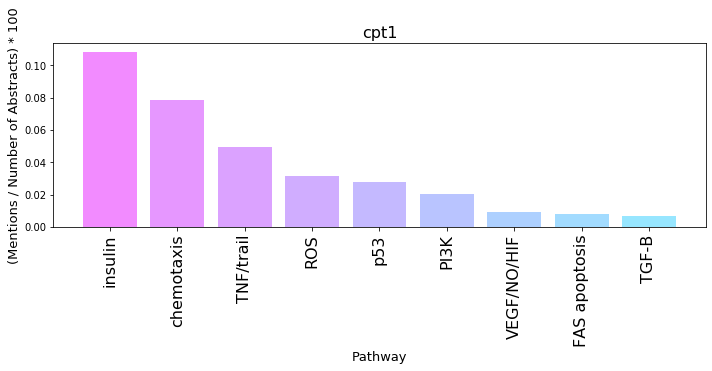

In [57]:
plot_top_categories('cpt1')
plt.xticks(fontsize=16)
plt.title('cpt1',fontsize=16)
plt.tight_layout()
plt.savefig('cpt1.jpg')

In [62]:
def plot_top_categories_other(string):
    '''
    Plot a bar graph of category representation for other token
    '''
    output = top_categories_other(string)
    colors = plt.cm.cool(np.linspace(0.1,0.9,10))[::-1]
    plt.figure(figsize=(10,5))
    plt.bar(x=range(len(output)),height=list(map(lambda x:x[1],output)),color=colors,alpha=0.5)
    plt.xticks(ticks=range(len(output)),labels=list(map(lambda x:x[0],output)),rotation=90,fontsize=13)
    plt.xlabel('Pathway',fontsize=13)
    plt.ylabel('(Mentions / Number of Abstracts) * 100',fontsize=13)
    plt.title(string, fontsize=14)

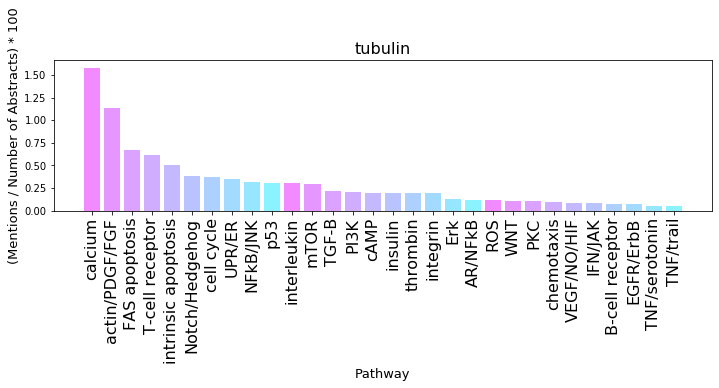

In [68]:
plot_top_categories('tubulin')
plt.xticks(fontsize=16)
plt.title('tubulin',fontsize=16)
plt.tight_layout()
plt.savefig('tubulin.jpg')

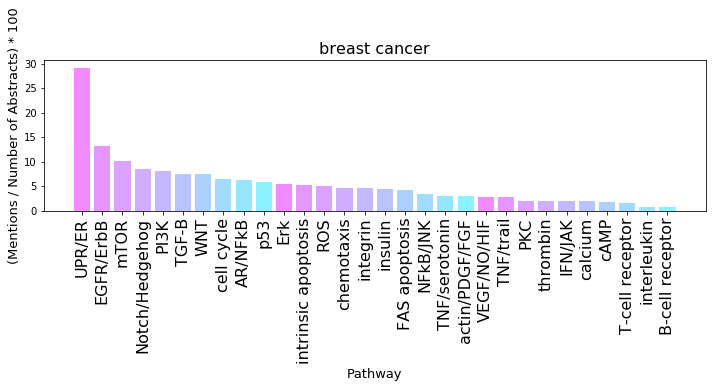

In [64]:
plot_top_categories_other('breast cancer')
plt.xticks(fontsize=16)
plt.title('breast cancer',fontsize=16)
plt.tight_layout()
plt.savefig('breast cancer.jpg')

I saved a dataframe of the top 30 genes in each cluster

In [51]:
final_dict = {}

for i in range(0,30):
    final_dict[topic_labels[i]] = genes_dict[i].head(30).index

In [53]:
pd.set_option('display.max_columns', None)
pd.DataFrame(final_dict,index=range(0,30))

,integrin,mTOR,calcium,Erk,p53,FAS apoptosis,insulin,TGF-B,cAMP,Notch/Hedgehog,UPR/ER,EGFR/ErbB,VEGF/NO/HIF,WNT,intrinsic apoptosis,IFN/JAK,TNF/trail,chemotaxis,TNF/serotonin,B-cell receptor,PI3K,NFkB/JNK,actin/PDGF/FGF,ROS,thrombin,PKC,interleukin,T-cell receptor/GPCRs,AR/NFkB,cell cycle
0,integrin,akt,src,erk,p53,fas,insulin,tgf-beta,camp,notch,er,egfr,vegf,wnt,stat3,ifn,tnf,cxcr4,tnf-alpha,antigen,akt,nf-kappab,actin,nrf2,thrombin,pkc,il-2,tcr,nf-κb,ras
1,fak,mtor,bcr,mapk,atm,caspase,igf-i,rho,pka,notch1,upr,egf,no,β-catenin,bcl-2,ifn-gamma,trail,cd4,collagen,bcr,pi3k,jnk,pdgf,cox-2,tf,protein kinase c,protein kinase c,gpcrs,ar,p53
2,fibronectin,pi3k,s1p,erk1,p21,il-6,igf-1,smad,cftr,hedgehog,estrogen receptor,epidermal growth factor receptor,vascular endothelial growth factor,beta-catenin,il-6,stat1,nf-κb,cd8,bdnf,apc,erk,p38,actin cytoskeleton,hgf,par1,pka,il-15,src,androgen,c-myc
3,focal adhesion kinase,pten,abl,p38,mdm2,bcl-2,akt,tgf,creb,hh,erα,her2,cgmp,tcf,bax,tlr,tumor necrosis factor,cxcl12,il-1beta,ige,ampk,ap-1,clathrin,leptin,par-1,erk,interleukin-2,g-protein,il-8,rb
4,ilk,mtorc1,apc,jnk,chk1,stat3,igf,rhoa,protein kinase a,paf,perk,epidermal growth factor,gh,bmp,caspase-3,stat,il-6,pd-1,5-ht,cd28,mtor,c-jun,rac1,met,pars,pkcalpha,il-7,syk,ubiquitin,myc
5,paxillin,ampk,[ca2+]i,mek,bax,fasl,irs-1,beta-catenin,epac,hes1,chop,akt,nitric oxide,apc,cytochrome c,toll,dr5,ccr5,mmp-9,pd-1,mapk,erk,fgf,c-met,csf,mapk,stat5,plc,tlr4,p21
6,src,phosphatidylinositol 3-kinase,tcr,p38 mapk,rb,caspase-3,insulin receptor,smad3,hcg,notch3,grp78,egf receptor,enos,dkk1,caspase,tlrs,caspase,sdf-1,tgf-beta1,toll,pten,mapk,cdc42,pge2,par2,erk1,il-2r,phospholipase c,androgen receptor,bcl-2
7,collagen,pik3ca,protein-protein,mitogen-activated protein kinase,chk2,bax,igf-1r,smad2,adenylyl cyclase,dll4,stim1,erk,vegfr2,wnt5a,caspase-9,jak,caspase-8,cd3,nf-kappab,cd40,erk1,tnfalpha,rac,app,fibrinogen,pkcdelta,jak3,lck,epo,bax
8,igg,mtorc2,trpv1,ras,arf,caspase-8,leptin,wnt,lh,notch2,pr,erbb2,inos,wnt3a,bcl-xl,ifn-alpha,jnk,cxcr7,tumor necrosis factor-alpha,tlr,insulin,c-jun n-terminal kinase,f-actin,hsp90,par,marcks,calcineurin,rgs,tlr2,e2f
9,laminin,phosphoinositide 3-kinase,gnrh,nf-kappab,cip1,cd95,adiponectin,e-cadherin,pde4,jagged1,eralpha,erbb,hif-1alpha,catenin,gp130,il-10,tnfr1,antigen,gr,syk,ras,ikappabalpha,ret,il-4,apc,plc,cd28,zap-70,p65,p27


In [54]:
#with open('final_dict.pickle', 'wb') as write_file:
#    pickle.dump(final_dict, write_file)

In [57]:
final_other_dict = {}

for i in range(0,30):
    final_other_dict[topic_labels[i]] = other_dict[i].head(30).index

In [58]:
pd.set_option('display.max_columns', None)
pd.DataFrame(final_other_dict,index=range(0,30))

,integrin,mTOR,calcium,Erk,p53,FAS apoptosis,insulin,TGF-B,cAMP,Notch/Hedgehog,UPR/ER,EGFR/ErbB,VEGF/NO/HIF,WNT,intrinsic apoptosis,IFN/JAK,TNF/trail,chemotaxis,TNF/serotonin,B-cell receptor,PI3K,NFkB/JNK,actin/PDGF/FGF,ROS,thrombin,PKC,interleukin,T-cell receptor/GPCRs,AR/NFkB,cell cycle
0,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,cell,platelet,cell,cell,cell,cell,cell
1,tumor,tumor,ca2+,tumor,dna,patient,glucose,tumor,intracellular,tumor,endoplasmic reticulum,tumor,no,tumor,mitochondrial,patient,patient,patient,patient,t cells,tumor,cellular,cellular,patient,cell,ca2+,t cells,ca2+,tumor,dna
2,extracellular matrix,rapamycin,calcium,cellular,tumor,tumor,mouse,cancer,ca2+,cancer,ca2+,patient,tumor,bone,tumor,mouse,mouse,tumor,cellular,t cell,cancer,dna,membrane,tumor,patient,calcium,patient,t cells,prostate cancer,tumor
3,cellular,cancer,cellular,patient,cancer,dna,patient,patient,cellular,patient,estrogen,cancer,patient,cancer,mitochondrion,tumor,lps,t cells,tissue,tumor,patient,tumor,tumor,cellular,ca2+,cellular,ca2+,cellular,patient,cancer
4,platelet,patient,patient,cancer,cellular,mitochondrial,human,cellular,patient,mouse,cellular,gefitinib,cellular,patient,dna,human,tumor,hiv-1,mouse,t-cell,cellular,ros,patient,cancer,calcium,tpa,t cell,t cell,cancer,cellular
5,cancer,cellular,intracellular,mouse,patient,cancer,cellular,mouse,calcium,human,breast cancer,cellular,vascular,mouse,cancer,cellular,cancer,hiv,human,b cells,mouse,cancer,cancer,mouse,blood,membrane,calcium,calcium,cellular,patient
6,ecm,mouse,human,dna,atr,cellular,live,bone,human,cellular,tumor,cetuximab,mouse,tissue,patient,dna,macrophage,t cell,tumor,dcs,mitochondrial,patient,intracellular,human,endothelial cells,intracellular,cellular,membrane,mouse,mouse
7,tissue,ly294002,membrane,human,mouse,mouse,adipocyte,tissue,forskolin,tissue,cancer,erlotinib,endothelial cells,human,ros,macrophage,cellular,mouse,platelet,patient,human,nuclear,mouse,dna,cellular,pma,intracellular,intracellular,dna,human
8,matrix,breast cancer,mouse,ros,cancer cells,mitochondrion,tissue,human,mouse,stem cell,calcium,mouse,cancer,cellular,cellular,cancer,human,cancer,brain,cellular,rapamycin,lps,human,ca2+,tissue,patient,human,tyrosine,lps,cancer cells
9,intracellular,human,cancer,intracellular,mitochondrial,ros,lipid,mesenchymal,membrane,breast cancer,patient,breast cancer,nitric oxide,nuclear,mouse,t cells,monocyte,human,intracellular,mouse,ros,mouse,tissue,tissue,tumor,dna,tyrosine,human,human,mitochondrial


In [59]:
#with open('final_other_dict.pickle', 'wb') as write_file:
#    pickle.dump(final_other_dict, write_file)